In [1]:
import time
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt

#from mapper.ssc import ssc

In [2]:
def to_celsius(image):
    """Convert raw intensity values of radiometric image to Celsius scale."""
    return image*0.04-273.15


def preprocess_radiometric_frame(frame, equalize_hist=True):
    """Preprocesses raw radiometric frame.

    First, the raw 16-bit radiometric intensity values are converted to Celsius
    scale. Then, the image values are normalized to range [0, 255] and converted
    to 8-bit. Finally, histogram equalization is performed to normalize
    brightness and enhance contrast.
    """
    frame = to_celsius(frame)
    frame = (frame - np.min(frame)) / (np.max(frame) - np.min(frame))
    frame = (frame*255.0).astype(np.uint8)
    if equalize_hist:
        frame = cv2.equalizeHist(frame)
        # CLAHE results in vastly different numbers of feature points depending on clipLimit
        #clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(8,8))
        #frame = clahe.apply(frame)
    return frame

In [3]:
def extract_keypoints(frame, fast, orb, max_points=None):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    kp = fast.detect(frame, None)
    kp = sorted(kp, key=lambda x:x.response, reverse=True)
    if max_points is not None:
        kp = kp[:max_points]
    kp, des = orb.compute(frame, kp)
    return kp, des


def extract_keypoints_orb(frame):
    """Extracts FAST feature points and ORB descriptors in the frame."""
    orb = cv2.ORB_create(nfeatures=5000, fastThreshold=12)
    kp = orb.detect(frame, None)
    kp, des = orb.compute(frame, kp)
    return kp, des


def match(bf, last_keyframe, frame, last_des, des, last_kp, kp, distance_threshold=30.0, draw=True):
    matches = bf.match(last_des, des)
    matches = sorted(matches, key=lambda x:x.distance)
    # filter out matches with distance (descriptor appearance) greater than threshold
    matches = [m for m in matches if m.distance < distance_threshold]
    print("Found {} matches of current frame with last key frame".format(len(matches)))
    last_pts = np.array([last_kp[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
    current_pts = np.array([kp[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)
    match_frame = np.zeros_like(frame)
    if draw:
        match_frame = cv2.drawMatches(last_keyframe, last_kp, frame, kp, matches, None)
    return matches, last_pts, current_pts, match_frame

In [4]:
camera_matrix = pickle.load(open("../camera_calibration/parameters/ir/camera_matrix.pkl", "rb"))
dist_coeffs = pickle.load(open("../camera_calibration/parameters/ir/dist_coeffs.pkl", "rb"))

img_w = 640
img_h = 512
new_camera_matrix = camera_matrix
mapx, mapy = cv2.initUndistortRectifyMap(
    camera_matrix, dist_coeffs, None,
    new_camera_matrix, (img_w, img_h), cv2.CV_32FC1)

In [5]:
def load_image(image_file):
    frame = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)
    frame = preprocess_radiometric_frame(frame, equalize_hist=True
                                        )
    frame = cv2.remap(frame, mapx, mapy, cv2.INTER_CUBIC)
    return frame

In [6]:
img0 = load_image("frame_001307.tiff")
img1 = load_image("frame_001308.tiff")

In [7]:
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
fast = cv2.FastFeatureDetector_create(threshold=12, nonmaxSuppression=True)
distance_threshold = 20.0

In [14]:
#kp0, des0 = extract_keypoints(img0, fast, orb)#, max_points=5000)
#kp1, des1 = extract_keypoints(img1, fast, orb)#, max_points=5000)

kp0, des0 = extract_keypoints_orb(img0)#, max_points=5000)
kp1, des1 = extract_keypoints_orb(img1)#, max_points=5000)

print(len(kp0), len(kp1))

3440 3395


In [15]:
set([kp.octave for kp in kp0])

{0, 1, 2, 3, 4, 5, 6, 7}

In [231]:
dts = []
for _ in range(10):
    t0 = time.perf_counter()
    matches = bf.match(des0, des1)
    dt = time.perf_counter() - t0
    dts.append(dt)
print(np.mean(dts), np.std(dts))
#matches = sorted(matches, key=lambda x:x.distance)
# filter out matches with distance (descriptor appearance) greater than threshold
matches = [m for m in matches if m.distance < distance_threshold]
print("Found {} matches of current frame with last key frame".format(len(matches)))
pts0 = np.array([kp0[m.queryIdx].pt for m in matches]).reshape(1, -1, 2)
pts1 = np.array([kp1[m.trainIdx].pt for m in matches]).reshape(1, -1, 2)
match_frame = np.zeros_like(img0)
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = None,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
match_frame = cv2.drawMatches(img0, kp0, img1, kp1, matches, None, **draw_params)

0.03759264069376513 0.001254954775692971
Found 745 matches of current frame with last key frame


In [233]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2

search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params, search_params)
#matches = flann.knnMatch(des0, des1, k=2)

dts = []
for _ in range(10):
    t0 = time.perf_counter()
    matches = flann.knnMatch(des0, des1, k=2)
    dt = time.perf_counter() - t0
    dts.append(dt)
print(np.mean(dts), np.std(dts))

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
mask = [False for i in range(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        mask[i] = True
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
match_frame = cv2.drawMatchesKnn(img0, kp0, img1, kp1, matches, None, **draw_params)
mask = np.array(mask)
print("Found {} matches of current frame with last key frame".format(sum(mask)))

0.04541452100966126 0.005106251703058949
Found 910 matches of current frame with last key frame


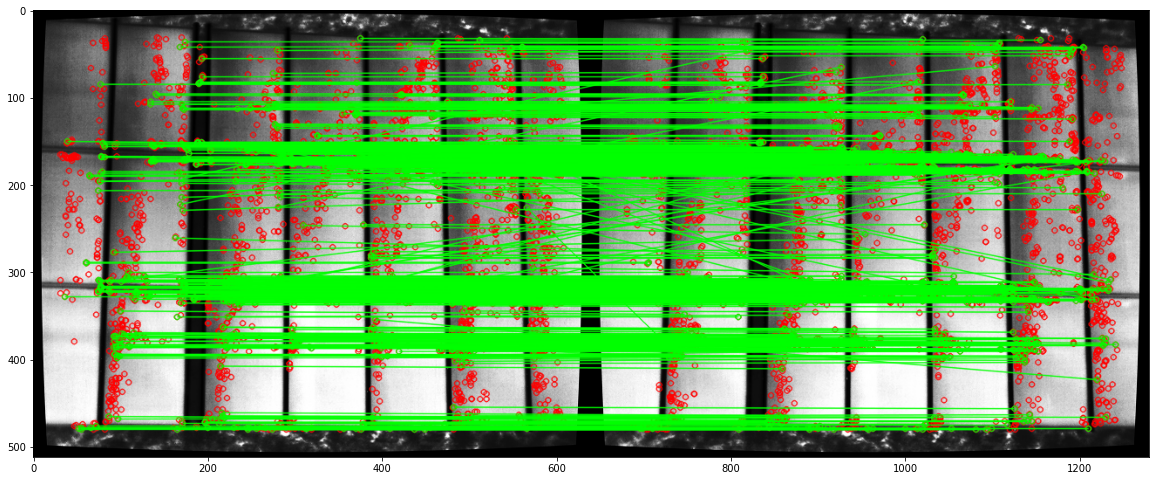

In [232]:
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(match_frame)
plt.show()

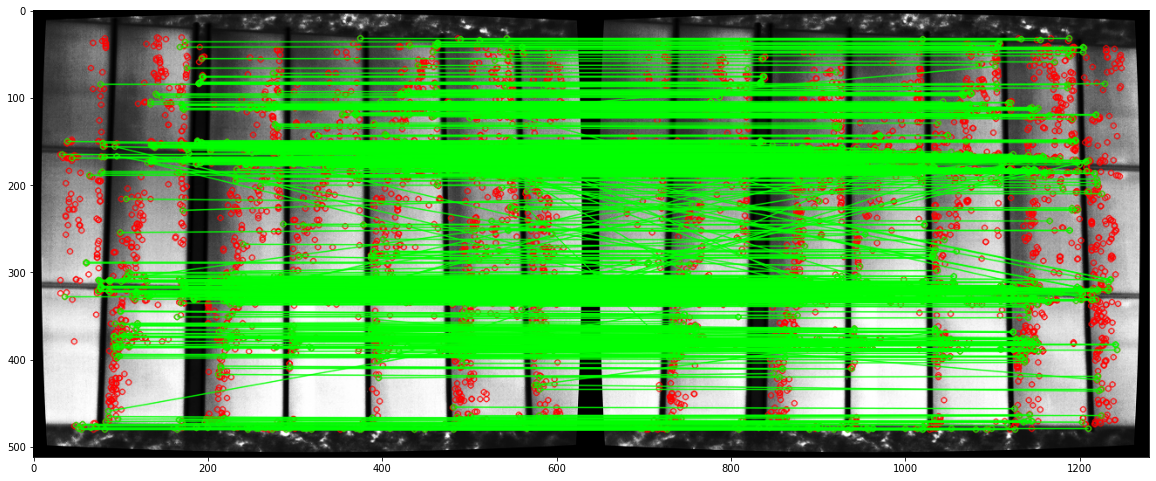

In [234]:
fig = plt.figure()
fig.set_size_inches(20, 10)
plt.imshow(match_frame)
plt.show()